In [1]:
import pandas as pd
import tensorflow as tf
import keras as ks
import numpy as np
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import datetime
import time
from math import floor
import models.scripts.logistic_regression_functions as lrf
import models.scripts.helper_functions as hf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, Activation, MaxPooling2D
import matplotlib.pylab as plt
import seaborn as sns

C:\Users\mccomackjp\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Load the data
df = pd.read_csv('../data/cleaned/utah_2017_vineyard.csv')
target_col = 'BGA-Phycocyanin RFU'
df.dtypes

Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
Chlorophyll (ug/L)     float64
Chlorophyll RFU        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object

In [3]:
# Create a single datetime column from the strings provided in our csv's
# (We're already doing this bit for our models)

timestamp = df['Date (mm.dd.yyyy)'] + ' '+ df['Time 24hr']
timestamp = pd.to_datetime(timestamp)
df['timestamp'] = timestamp

# I'll drop the other columns for simple demo purposes
df = df[['timestamp', 'pH', 'BGA-Phycocyanin RFU']]
df['temp'] = [x for x in range(0, df.shape[0])]

df.dtypes

timestamp              datetime64[ns]
pH                            float64
BGA-Phycocyanin RFU           float64
temp                            int64
dtype: object

In [4]:
# Now we set our datetime to be the index of the df for awesome indexing options
# Note, the column is removed, so it might be good to keep a copy by another
# name for feature engineering.
df['datetime'] = df['timestamp']
df = df.set_index('timestamp')
df.dtypes


pH                            float64
BGA-Phycocyanin RFU           float64
temp                            int64
datetime               datetime64[ns]
dtype: object

In [5]:
# Index into a range of dates
df['2017-05-05 00:15:00':'2017-05-05 00:45:00']

,pH,BGA-Phycocyanin RFU,temp,datetime
timestamp,,,,
2017-05-05 00:15:00,8.36,0.4,1,2017-05-05 00:15:00
2017-05-05 00:30:00,8.36,0.4,2,2017-05-05 00:30:00
2017-05-05 00:45:00,8.36,0.4,3,2017-05-05 00:45:00


In [6]:
# Index with an offset
start = df['datetime'][0]
delta = pd.Timedelta(1, unit='h')
print("start:", start)
print(delta)
offset = pd.Timedelta(1, 'm')
# grab a slice over 1 hour
df[start:start + delta]

start: 2017-05-05 00:00:00
0 days 01:00:00


,pH,BGA-Phycocyanin RFU,temp,datetime
timestamp,,,,
2017-05-05 00:00:00,8.36,0.4,0,2017-05-05 00:00:00
2017-05-05 00:15:00,8.36,0.4,1,2017-05-05 00:15:00
2017-05-05 00:30:00,8.36,0.4,2,2017-05-05 00:30:00
2017-05-05 00:45:00,8.36,0.4,3,2017-05-05 00:45:00
2017-05-05 01:00:00,8.36,0.4,4,2017-05-05 01:00:00


In [7]:
df[start+delta+offset: start+delta+delta]

,pH,BGA-Phycocyanin RFU,temp,datetime
timestamp,,,,
2017-05-05 01:15:00,8.36,0.4,5,2017-05-05 01:15:00
2017-05-05 01:30:00,8.36,0.4,6,2017-05-05 01:30:00
2017-05-05 01:45:00,8.36,0.4,7,2017-05-05 01:45:00
2017-05-05 02:00:00,8.36,0.4,8,2017-05-05 02:00:00


In [8]:
df[start:start + delta].describe()

,pH,BGA-Phycocyanin RFU,temp
count,5.00,5.0,5.000000
mean,8.36,0.4,2.000000
std,0.00,0.0,1.581139
min,8.36,0.4,0.000000
25%,8.36,0.4,1.000000
50%,8.36,0.4,2.000000
75%,8.36,0.4,3.000000
max,8.36,0.4,4.000000


In [9]:
df[start:start + delta].quantile(.5, numeric_only=False)['datetime']

Timestamp('2017-05-05 00:30:00')

In [10]:
test = df[start:start + delta]['temp']
print("0%", test.quantile(0.0))
print("25%", test.quantile(0.25))
print("50%", test.quantile(0.5))
print("75%", test.quantile(0.75))
print("100%", test.quantile(1))
df[start:start + delta].describe()

0% 0.0
25% 1.0
50% 2.0
75% 3.0
100% 4.0


,pH,BGA-Phycocyanin RFU,temp
count,5.00,5.0,5.000000
mean,8.36,0.4,2.000000
std,0.00,0.0,1.581139
min,8.36,0.4,0.000000
25%,8.36,0.4,1.000000
50%,8.36,0.4,2.000000
75%,8.36,0.4,3.000000
max,8.36,0.4,4.000000


In [11]:
temp = df[start:start + delta]
a = temp[0:0]
a = a.append(temp.quantile(.5, numeric_only=False))

In [12]:
dfs = [df[start:start + delta], df[start+delta+offset: start+delta+delta]]


In [13]:
# extracted = dfs[0][0:0] # start with a blank data frame with the same setup
extracted = pd.DataFrame()
for d in dfs:
    extracted = extracted.append(d.quantile(.5, numeric_only=False))
extracted['datetimeIndex'] = extracted['datetime']
extracted = extracted.set_index('datetimeIndex')

In [14]:
extracted

,BGA-Phycocyanin RFU,datetime,pH,temp
datetimeIndex,,,,
2017-05-05 00:30:00,0.4,2017-05-05 00:30:00,8.36,2.0
2017-05-05 01:37:30,0.4,2017-05-05 01:37:30,8.36,6.5


In [15]:
pd.date_range(start='2018-01-01', periods=10, freq='d')

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10'],
              dtype='datetime64[ns]', freq='D')

In [16]:
df['datetime'][len(df['datetime'])-1]

Timestamp('2017-11-18 08:30:00')

In [17]:
start = df['datetime'][0]
df[start:start + pd.Timedelta(1, 'm')]

,pH,BGA-Phycocyanin RFU,temp,datetime
timestamp,,,,
2017-05-05,8.36,0.4,0,2017-05-05


In [18]:
df.describe()

,pH,BGA-Phycocyanin RFU,temp
count,18947.000000,18947.000000,18947.000000
mean,8.633415,0.979511,9473.000000
std,0.147231,0.731423,5469.672111
min,7.930000,0.000000,0.000000
25%,8.530000,0.500000,4736.500000
50%,8.650000,0.900000,9473.000000
75%,8.700000,1.200000,14209.500000
max,9.230000,16.100000,18946.000000


In [19]:
df.columns

Index(['pH', 'BGA-Phycocyanin RFU', 'temp', 'datetime'], dtype='object')

In [20]:
print(type(df.quantile(.5)))
df['datetime'].quantile(.5)

<class 'pandas.core.series.Series'>


Timestamp('2017-08-11 16:15:00')

In [21]:
def segment(df, time_col, x_win, y_win, shift):
    segments = []
    targets = []
    start = df[time_col][0]
    end = df[time_col][len(df[time_col])-1]
    offset = pd.Timedelta(1, unit='s') # to remove overlap of x and y
    while start + x_win + y_win <= end:
        segments.append(df[start:start + x_win])
        targets.append(df[start  + x_win + offset : start + x_win + y_win])
        start += shift
    return segments, targets
        

In [22]:
s, t = segment(df, 
               'datetime', 
               pd.Timedelta(2, unit='d'), pd.Timedelta(1, unit='d'),
        pd.Timedelta(6, unit='h'))

In [23]:
sum(range(0,10))/10

4.5

In [24]:
[i for i in range(0, 10)]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

## Segment tests

In [25]:
df['month'] = df['datetime'].apply(lambda date: date.month).astype('category')
print(df['month'].describe())
print(df.dtypes)
months = dict()
for month in df['month'].values:
    if month in months:
        months[month] = months[month] + 1
    else:
        months[month] = 1
print(months)

count     18947
unique        7
top          10
freq       2976
Name: month, dtype: int64
pH                            float64
BGA-Phycocyanin RFU           float64
temp                            int64
datetime               datetime64[ns]
month                        category
dtype: object
{5: 2592, 6: 2880, 7: 2976, 8: 2976, 9: 2880, 10: 2976, 11: 1667}


### Segmenting categories

In [26]:
s, t = hf.segment_dataset(df, 'datetime')
s[0].head()

,pH,BGA-Phycocyanin RFU,temp,datetime,month
timestamp,,,,,
2017-05-05 00:00:00,8.36,0.4,0,2017-05-05 00:00:00,5
2017-05-05 00:15:00,8.36,0.4,1,2017-05-05 00:15:00,5
2017-05-05 00:30:00,8.36,0.4,2,2017-05-05 00:30:00,5
2017-05-05 00:45:00,8.36,0.4,3,2017-05-05 00:45:00,5
2017-05-05 01:00:00,8.36,0.4,4,2017-05-05 01:00:00,5


In [27]:
df.quantile(0.95)

pH                         8.9
BGA-Phycocyanin RFU        2.1
temp                   17998.7
Name: 0.95, dtype: float64

In [28]:
df['datetime'].quantile(0.95)

Timestamp('2017-11-08 11:40:30')

In [29]:
# Should perform feature engineering and category manipulation after extraction.
df['month'].quantile(0.95)

11.0

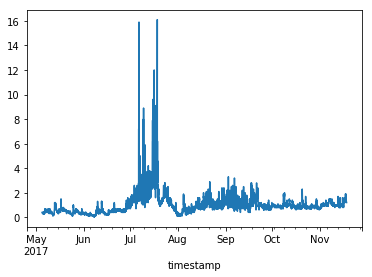

In [30]:
# Prior to segmenting
df[target_col].plot.line()

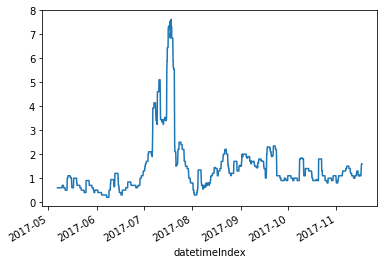

In [31]:
# Shouldn't extract categorical data, we'll do feature engineering after 
segments, targets = hf.segment_dataset(df.drop(columns=['month']), 'datetime')
x_df = hf.extract_percentile(segments, 'datetime')
y_df = hf.extract_percentile(targets, 'datetime')
x_df[target_col].plot.line()

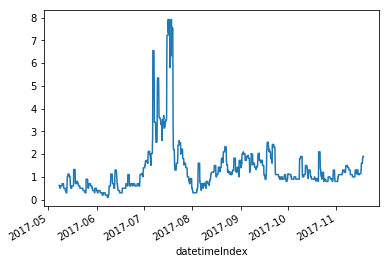

In [32]:
y_df[target_col].plot.line()

In [35]:
y_df.describe()

,BGA-Phycocyanin RFU,pH,temp
count,4665.000000,4665.000000,4665.000000
mean,1.366988,8.696669,9611.250000
std,1.175186,0.174359,5387.255331
min,0.100000,8.370000,283.250000
25%,0.700000,8.600000,4947.250000
50%,1.100000,8.680000,9611.250000
75%,1.600000,8.790000,14275.250000
max,7.925000,9.132500,18939.250000


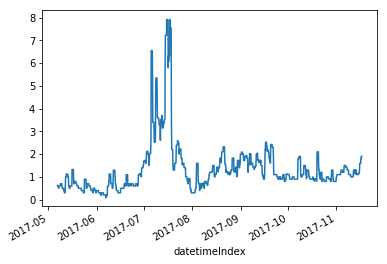

In [38]:
combined = x_df
combined[target_col] = y_df[target_col].values
combined[target_col].plot.line()

In [ ]:
combined